# WebScraping

## 1. Imports

In [51]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


## 2. Download HTML

In [52]:
#---CONECTAR API---
url = "https://ycharts.com/companies/TSLA/revenues"
headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"}
response = requests.get(url, headers = headers)

#Ahora tenemos todo el HTML
html_data = response.text

## 3. Transform HTML

In [53]:
#Ahora usaremos BeautifulSoup para poder buscar en el HMTL
soup = BeautifulSoup(html_data, "html.parser")

#Ahora buscaremos las tablas que tenemos en nuestro HTML
tables = soup.find_all('table')

## 4. Dataframe creation

In [54]:
def convertidor_de_millones(x):
    #Esta funcion me va a ayudar a poner todos los billones y millones correspondiente a su valor real
    if x.endswith("B"):
        new_value = float(x.replace("B",""))
        return new_value * 1000
    elif x.endswith("M"):
        new_value = float(x.replace("M",""))
        return new_value

tesla_revenue = pd.DataFrame(columns= ["Date", "Revenue"])

#Agregar valores al DataFrame
for i in range(2):
    for row in tables[i].tbody.find_all("tr"):
        col = row.find_all("td")
        Date = col[0].text
        Revenue = col[1].text.strip()
        tesla_revenue = pd.concat([tesla_revenue, pd.DataFrame({
            "Date":Date,
            "Revenue":Revenue
        }, index=[0])], ignore_index=True)

#Aplicar convertidor de Billones y Millones a nuestro data frame
tesla_revenue["Revenue"] = tesla_revenue["Revenue"].apply(convertidor_de_millones)
#Convertir Data en una fecha mas maneable
tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])

tesla_revenue.head(5)


,Date,Revenue
0,2024-09-30,25180.0
1,2024-06-30,25500.0
2,2024-03-31,21300.0
3,2023-12-31,25170.0
4,2023-09-30,23350.0


## 4. SQLite

In [55]:
connection = sqlite3.connect('tesla_database.db')
tesla_revenue.to_sql('revenue', connection, if_exists='replace', index=False)
connection.commit()

In [56]:
base_de_datos = pd.read_sql("SELECT * FROM revenue", con=connection)
base_de_datos

,Date,Revenue
0,2024-09-30 00:00:00,25180.00
1,2024-06-30 00:00:00,25500.00
2,2024-03-31 00:00:00,21300.00
3,2023-12-31 00:00:00,25170.00
4,2023-09-30 00:00:00,23350.00
5,2023-06-30 00:00:00,24930.00
6,2023-03-31 00:00:00,23330.00
7,2022-12-31 00:00:00,24320.00
8,2022-09-30 00:00:00,21450.00
9,2022-06-30 00:00:00,16930.00


In [57]:
connection.close()

## 5. Data visualization

In [58]:
view_table_1 = tesla_revenue.copy()
view_table_1 = view_table_1.sort_values(by="Date")

### Company revenue over time

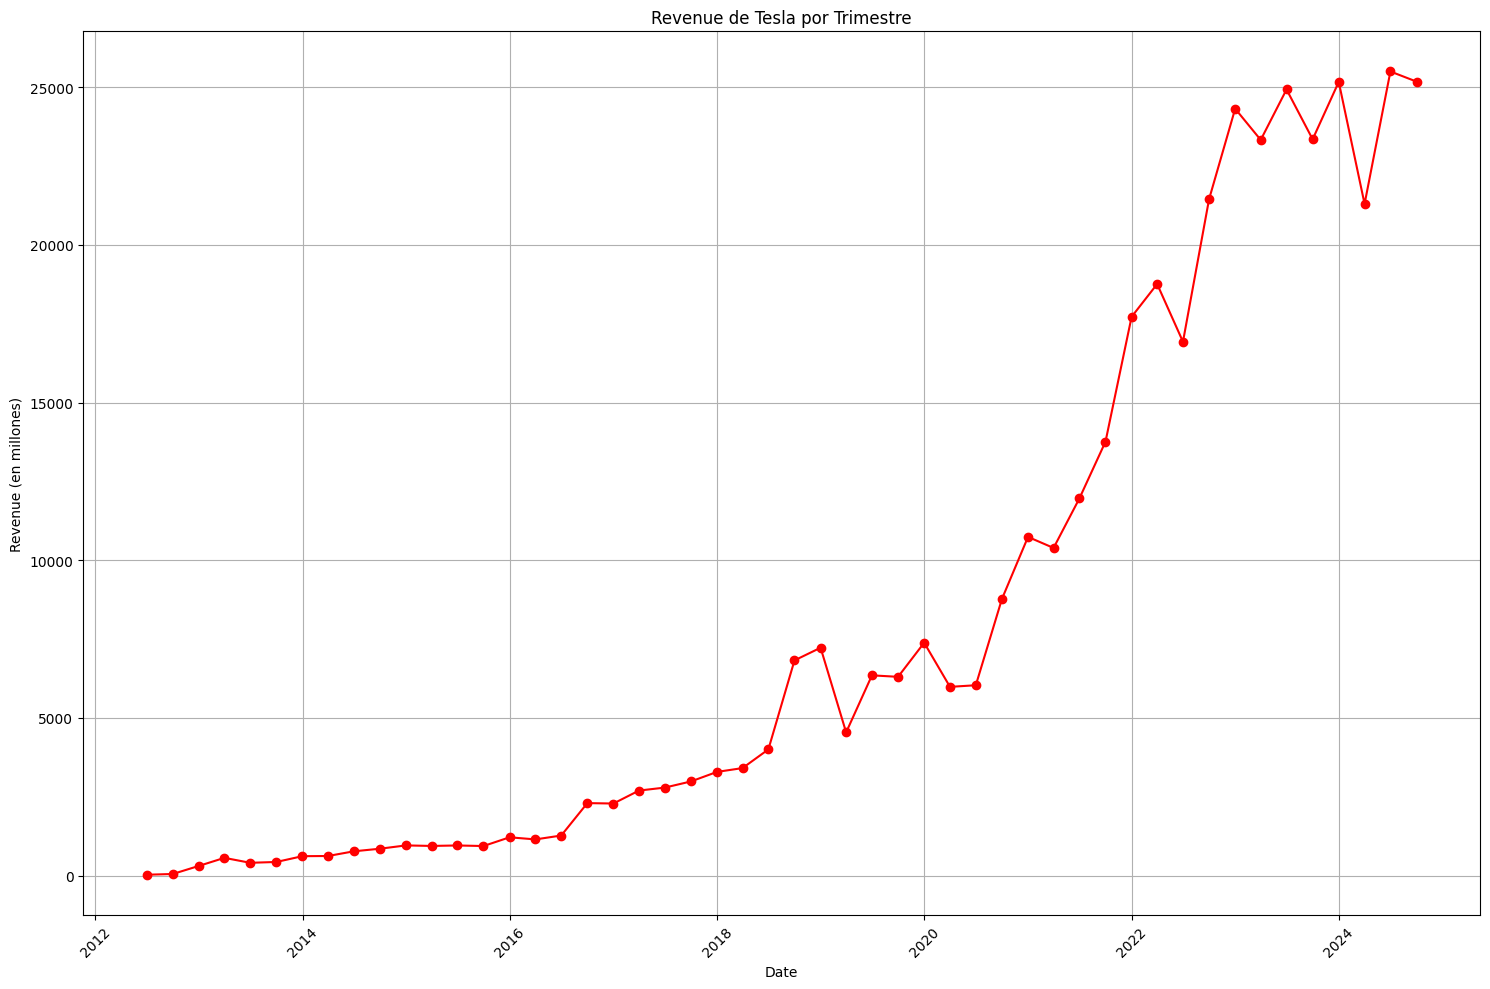

In [59]:
plt.figure(figsize=(15, 10))
plt.plot(view_table_1['Date'], view_table_1['Revenue'], marker='o', linestyle='-', color='r')

plt.title('Revenue de Tesla por Trimestre')
plt.xlabel('Date')
plt.ylabel('Revenue (en millones)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

### Annual gross profit

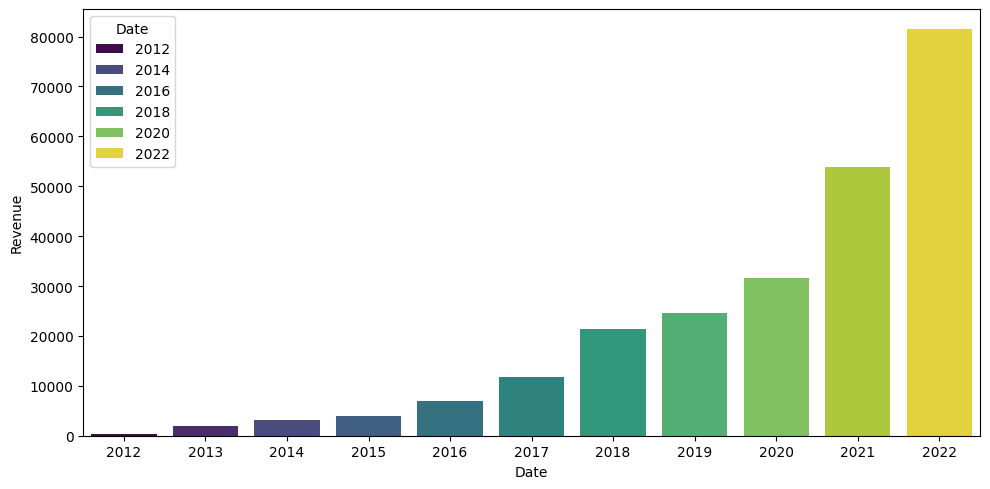

In [60]:
fig, axis = plt.subplots(figsize=(10, 5))

tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])

tesla_revenue_yearly = tesla_revenue.groupby(tesla_revenue["Date"].dt.year)["Revenue"].sum().reset_index()

sns.barplot(data = tesla_revenue_yearly[tesla_revenue_yearly["Date"] < 2023], x = "Date", y = "Revenue", hue = "Date", palette="viridis")

plt.tight_layout()
plt.show()


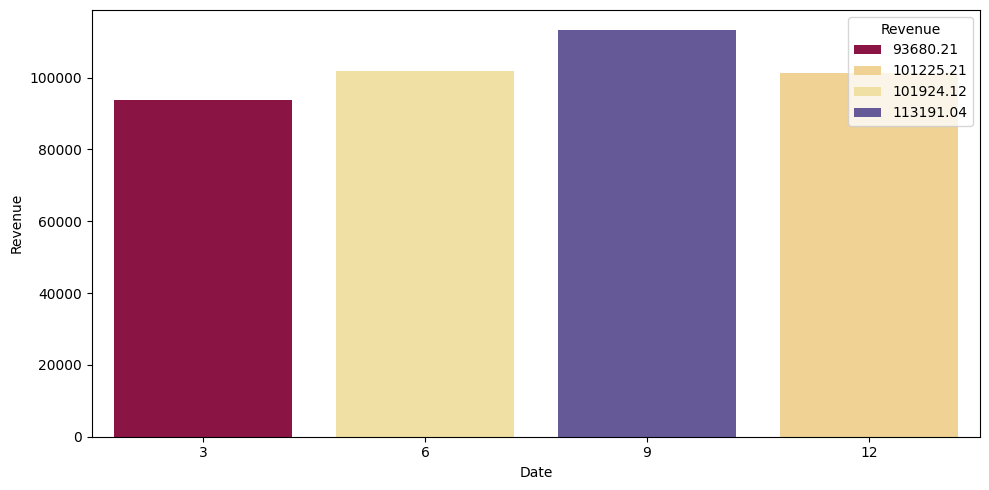

In [61]:
fig, axis = plt.subplots(figsize = (10,5))

tesla_revenue_monthly = tesla_revenue.groupby(tesla_revenue["Date"].dt.month)["Revenue"].sum().reset_index()

sns.barplot(data = tesla_revenue_monthly, x = "Date", y = "Revenue", hue = "Revenue", palette="Spectral")

plt.tight_layout()
plt.show()